**MSc Final Project**

Inherited Retinal Disease Literature Summarisation using Transformers

BART-based Transformer
Implementation

In [1]:
# !python -m spacy download en_core_web_md

In [2]:
!pip install transformers

In [4]:
import os
import re
import torch
import transformers
import spacy
from tqdm import tqdm
from transformers import BartForConditionalGeneration, BartTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BartForConditionalGeneration, BartTokenizer
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import numpy as np

/mnt/data/skanda/mambaforge/envs/gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def load_preprocessed_data(directory):
    abstracts = []
    main_texts = []
    filenames = []

    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                content = file.read()
                # Splitting the content into abstract and main text
                parts = content.split("\nMain Text:\n")
                if len(parts) > 1:
                    abstract = parts[0].replace("Abstract:\n", "").strip()
                    main_text = parts[1].strip()
                else:
                    abstract = ""
                    main_text = content  # Assuming all text is main if no abstract is defined

                abstracts.append(abstract)
                main_texts.append(main_text)
                filenames.append(filename)

    # Print the number of documents loaded
    print(f"Loaded {len(abstracts)} preprocessed documents.")

    return abstracts, main_texts, filenames

# Path to your preprocessed data directory
preprocessed_dir = "/path/to/your/preprocessed/data"

# Initialize variables
abstracts = []
main_texts = []
filenames = []

# Check if the directory exists
if not os.path.exists(preprocessed_dir):
    print(f"The directory {preprocessed_dir} does not exist.")
else:
    # Load the preprocessed data
    abstracts, main_texts, filenames = load_preprocessed_data(preprocessed_dir)

# Print a sample to verify
if abstracts:
    print("\nSample of first document:")
    print(f"Abstract: {abstracts[0][:500]}...")  # Print first 500 characters of the abstract
    print(f"Main Text: {main_texts[0][:500]}...")  # Print first 500 characters of the main text
else:
    print("No data to display.")



The directory /path/to/your/preprocessed/data does not exist.
No data to display.


In [6]:
def generate_summary(text, tokenizer, model, device, max_length=1024, min_length=800):
    try:
        # Encode text and truncate if necessary
        inputs = tokenizer.encode_plus(text, return_tensors="pt", truncation=True, max_length=max_length)
        text_length = len(inputs['input_ids'][0])
        
        # Calculate the target summary length (20% of the original text length)
        target_summary_length = max(int(text_length * 0.2), min_length)

        # Adjust max_length if necessary
        target_summary_length = min(target_summary_length, max_length)
        
        # Generate the summary with specified parameters
        summary_ids = model.generate(
            inputs['input_ids'].to(device), 
            max_length=target_summary_length,
            min_length=min_length, 
            length_penalty=2.0, 
            num_beams=4, 
            early_stopping=True
        )
        
        # Decode the generated tokens into a string
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary
    except Exception as e:
        print(f"Error in generating summary: {str(e)}")
        return ""

In [7]:
def evaluate_summary(reference, hypothesis):
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    return bleu_score, rouge_scores


In [8]:
def process_papers(preprocessed_data, reference_summaries, tokenizer, model, batch_size=5):
    assert len(preprocessed_data) == len(reference_summaries), "Mismatch between number of papers and abstracts"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    summaries = []
    bleu_scores = []
    rouge_scores_list = []

    for i in tqdm(range(0, len(preprocessed_data), batch_size), desc="Processing papers"):
        batch_data = preprocessed_data[i:i+batch_size]
        batch_abstracts = reference_summaries[i:i+batch_size]

        for doc, ref in zip(batch_data, batch_abstracts):
            if not ref:
                print(f"Skipping document with no abstract: {doc[:30]}...")
                continue

            summary = generate_summary(doc, tokenizer, model, device)
            bleu, rouge = evaluate_summary(ref, summary)

            summaries.append(summary)
            bleu_scores.append(bleu)
            rouge_scores_list.append(rouge)

            original_length = len(doc.split())
            abstract_length = len(ref.split())
            summary_length = len(summary.split())
            print(f"Original Length: {original_length}, Abstract Length: {abstract_length}, Summary Length: {summary_length}")
            print(f"Generated summary: {summary}")
            print(f"BLEU: {bleu}, ROUGE: {rouge}")

    return summaries, bleu_scores, rouge_scores_list

In [9]:
# Load model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)
nlp = spacy.load('en_core_web_md')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [10]:
# Load data
preprocessed_dir = '/mnt/data/skanda/MSc_IRD_LLM/data/data_preprocessed'
abstracts, main_texts, filenames = load_preprocessed_data(preprocessed_dir)

# Process data
summaries, bleu_scores, rouge_scores_list = process_papers(main_texts, abstracts, tokenizer, model)


Loaded 51 preprocessed documents.


Processing papers:   0%|          | 0/11 [00:00<?, ?it/s]

Original Length: 3660, Abstract Length: 146, Summary Length: 428
Generated summary: The majority of inherited eye diseases (IEDs) are caused by a single gene abnormality marked by extensive genetic and phenotypic heterogeneity. Panel-based genetic testing is able to identify the genetic cause of disease for approximately 67% of all patients with IRDs. There is only one FDA approved genebased therapy of IEDs: voretigene neparvovec-ryzl (Luxturna) for individuals with Leber congenital amaurosis and AR retinitis pigmentosa secondary to biallelic mutations in the RPE65 gene. There are no current therapeutics approved in the United States for mitochondrial disease. Reproductive technologies play a significant role in many other fields of medicine to help couples with family planning, fertility preservation, and fertility treatment in the setting of an inherited disorder. Those at risk of having a child with an inherited genetic disease should have the option to undergo in vitro fertilizatio

Processing papers:   9%|▉         | 1/11 [00:46<07:49, 47.00s/it]

Original Length: 5545, Abstract Length: 216, Summary Length: 500
Generated summary: Inherited retinal diseases (IRDs) are a diverse set of Mendelian disorders that are a major cause ofinherited blindness across the world. IRDs can be a feature of a multisystem disorder such as Usher syndrome, Bardet Biedl syndrome (BBS), Senior Loken syndrome and Joubert syndrome. The identi fication of the genetic basis of IRD can greatly assist the clinical diagnosis, counselling,treatment and management received on apatient-by-patient basis. This follow-up report outlines the success of this 105gene diagnostic test for the first 537 individuals with IRD referred from worldwide institutions anddescribes 131 new mutations in 45 genes as apotential cause of disease. DNA samples were enriched for the coding regions 50 bp of 105 genes (see online supplementary S1) and a speci fied intronic region of the CEP290 gene, using an Agilent SureSelect Custom Design target-enrichment kit. Sequencing reads were de

Processing papers:  18%|█▊        | 2/11 [01:28<06:33, 43.68s/it]

Original Length: 8370, Abstract Length: 71, Summary Length: 517
Generated summary: Avascular peripheral retina is a common feature of many pediatric retinal vascular diseases. The major differential diagnosis includes retinopathy of prematurity (ROP), familial exudative vitreoretinopathy (FEVR), Coats disease, incontinentia pigmenti (IP), Norrie disease, and persistent fetal vasculature (PFV) The persistent avascular retina can stimulate reactivation or recurrence of the vasoproliferation, as evidenced in studies of preterm infant eyes treated with bevacizumab for severe ROP.7 Persistent peripheral av vascular retina, identified as PAR in the new third edition of the International Classification of ROP, can correlate with the severity of Rop in the acute phase and with the risk of recurrence after ROP after skip areas (skip areas) Anti-VEGF injection can be observed after acute ROP in spontaneously regressed or even in former infants without any pathologic consequences (Figure 3). This

Processing papers:  27%|██▋       | 3/11 [02:09<05:41, 42.66s/it]

Original Length: 32746, Abstract Length: 183, Summary Length: 446
Generated summary: Autophagy is responsible for preserving homeostasis by degrading damaged or superfluous intracellular components of a wide range of sizes. Three main types of autophagy are described, each differing in the manner in which the cargo is delivered to the lysosome. Chaperone-mediated Autophagy (CMA) is a highly selective pathway. The recently described age associated with decline in eMI is compensated for through increased exocytic secreasis of superfluous or damaged proteins. In the retina, CMA has a high metabolic rate and has a key role in responding to internal and external stress, such as starvation and bacterial infection, which has been implicated in age-associated decline ineMI. The authors conclude that CMA is essential to maintain homeostatic conditions in physiolog - ical conditions such as bacterial infection and high metabolic rates in the retina. They conclude that the presence of CMA in meda

Processing papers:  36%|███▋      | 4/11 [02:50<04:53, 41.97s/it]

Original Length: 4679, Abstract Length: 236, Summary Length: 516
Generated summary: IRDs are now the most common cause of legal blindness in adults of working age in Australia and the UK. Genetic testing has evolved over the years, allowing case-by-case selection of appropriate molecular testing strategies. Success of genetic testing in identifying the disease-causing variant varies depending on patients specific diagnosis, age, and whether the responsible gene and/or pathogenic variant has been previously identified in IRD patients and/ or family members. There are over 30 active clinical trials for gene therapy for patients with IRD. This should betakenofhistoricalreferralprocesses,wheenetictes, and reassessment of IRD management to reassess the changes in several years following the recent Royal College of Ophthalmologists IRD guidelines. Patients referred to this retrospective evaluation of medical records of pre-existing patients of private Eye Surgery Associates of Victoria, Aust

Processing papers:  45%|████▌     | 5/11 [03:31<04:10, 41.72s/it]

Original Length: 20157, Abstract Length: 209, Summary Length: 497
Generated summary: Gene therapy offers a theoretical advantage over small molecules classically used as medi - cines: it is a one-shot treatment that can provide a durable and poten - tially curative clinical benefit. The journey from concept to clinical application has been long, including the development of an experi - mental approach around the identified medical needs. The ability of gene therapies to provide durable benefits to human health justifies continued optimism and increasing efforts towards making gene therapy part of our standard treatments. This review will outline strategies being explored in this direction and technologies needed for their successful translation. In the United States, Food and Drug Administration (FDA) and European Medicines Agency (EMA) approvals of the first gene therapy products occurred between 2017 and 2018, including chimeric antigen receptor (CAR)T cells to treat B cell malignanc

Processing papers:  55%|█████▍    | 6/11 [04:12<03:26, 41.36s/it]

Original Length: 5649, Abstract Length: 250, Summary Length: 431
Generated summary: methods employed in genetic studies on Retinal Dystrophies in India. Phenotypes studied, and the methods used to identify mutations in Indian families are shown above. All IRD patients need comprehensive low vision assessment and rehabilitation. Diagnostic and management challenges in a clinical set up in India with respect to IRDs and other IRDs are variable clinicalpresentation, lack of diagnostic and imaging tools in examining all IRDs, and lack of uniform guidelines for genetictesting. Figure 1 shows a timeline of major developments in this area of human genetics and genomics. Figure 2 shows a range of chosen genes from selective analysis of candidate candidates. Figure 3 shows a selection of genes from chosenmutations of candidate candidate candidates for genetic analysis of RP patients and their families. The most common inherited retinal dystrophie (IRDs) seen at L. V. Prasad Eye Institute (LVPEI

Processing papers:  64%|██████▎   | 7/11 [04:53<02:44, 41.15s/it]

Original Length: 8317, Abstract Length: 148, Summary Length: 485
Generated summary: Optic neuropathies are among the most common causes of blindness in the working age population. Inherited forms include Leber Hereditary Optic Neuropathy (LHON) and Dominant Optic Atrophy (DOA) LHON is a primary mitochondrial DNA (mtDNA) disorder, with the majority of cases caused by one of three point mutations. DOA is nuclear-encoded mitochondrial optic neuropathy caused by mutations in the OPA1 gene (3q28-q29), which encodes for a multimeric dynamin GTPase protein located within the mitochondrial inner membrane. Both LHON and DOA can mitigate some of these challenges and act as useful model diseases of more complex neurodegenerative disease processes. Transcriptomics can be used to interrogate mitochondrial dysfunction and the pathways that ultimately lead to cell loss and disease. As technologies and analysis techniques develop, the power of omics investigations is likely to increase. As well as the

Processing papers:  73%|███████▎  | 8/11 [05:35<02:04, 41.59s/it]

Original Length: 4339, Abstract Length: 250, Summary Length: 548
Generated summary: Retinitis pig mentosa (RP) is an inheritable retinal disor - der with an estimated prevalence of 1 in 4000 ~ 5000 in t he global population. It can be inherited in an autosomal dominant (AD), autosomal recessive (AR), X-linked (XL), or digenic pattern. RP is caused by mutations in many genes. The final pathway of pathological change is apoptosis of the photoreceptor cells (PRC) and the retinal pigment epithe - lium (RPE) This degradation ultimately leads to structural changes in the whole retina. When the retina undergoes structural changes, the choroid, which is entirely com - posed of vascular tissue, may be involved in retinal ves - sel narrowing. In this study, we evaluated the anatomical change s in the retina and choroids in patients with autoso - mal dominant RP (ADRP) and X- linked RP (XLRP) Materials and methods Participants We conducted a retrospective study including thirty-two chil - dren (6

Processing papers:  82%|████████▏ | 9/11 [06:19<01:24, 42.13s/it]

Original Length: 19, Abstract Length: 250, Summary Length: 391
Generated summary: Keywords genetherapy,inheritedretinaldegenerations,optogenetics. Supporting information Additional supporting information can be found online in the SupportingInformationsectionattheendofthe HTMLviewof thearticle. Peer Review History: Peer review history is available: Peer Review history isavailable: peerreviewhistory.com. For confidential support call the Samaritans on 08457 90 90 90 or visit a local Samaritans branch, see www.samaritans.org for details. In the U.S. call the National Suicide Prevention Lifeline on 1-800-273-8255. For international support, call the European Association for the Study of Suicide (ESL) on 1+1+1 +1 +1+. For the UK, contact the National Institute of Health and Social Security on 1 800 273 8255 or visit the National Institute of Social Security and The Institution for the Study for the Study of the Study in England and Wales on 08457 90 90 90. For more information on the Europ

Processing papers:  91%|█████████ | 10/11 [07:02<00:42, 42.58s/it]

Original Length: 4953, Abstract Length: 250, Summary Length: 540
Generated summary: Methods of literature search We conducted a systemic Medline database search on PubMed (October 10, 2022 ) using the following MeSH headings. We identified further articles from the reference lists of the retrieved articles. This review primarily relied on articles written in English. We reviewed non-English language articles that had abstracts translated. The authors report no commercial or proprietary interest in any product or concept discussed in this article. Patients have given consent for these images to be used in a prospective study approved by the Human Research Ethics Office of the University of Western Australia (2021/ET000151). Funding information This study was supported by the National Health & Medical Research Council of Australia (project and fellowship grant numbers: GNT1116360 (FKC) and MRF1142962 (FKc), the McCusker Foundation (FK) and the Miocevich Retina Fellowship (RCHJ), and the 

Processing papers: 100%|██████████| 11/11 [07:11<00:00, 39.23s/it]

Original Length: 11453, Abstract Length: 177, Summary Length: 532
Generated summary: Inherited retinal dystrophies (IRDs) encompass a diverse group of disorders affecting the structure and function of the retina. The genetic and clinical heterogeneity of these rare disorders can make diagnosis and prognosis challenging. Electrophysiological tests can help characterize IRDs by identifying the site of damage but also the cell type involved in the visual degenerative process. The oscillatory potentials (OPs) response reflects the interactions between bipolar cells, amacrine cells, and ganglion cells. The mfERG has also been used to assess the loss of cone function in the macula and peripheral regions of the retinal. In addition to clinical assessments, such as visual acuity, contrast sensitivity test, and visual field test, electrophysiology testing provides a unique objective evaluation of retinal function, which is critical for prognosis and treatment. The results of this study were pub

### **Evaluation**

In [17]:
def save_results(summaries, bleu_scores, rouge_scores, filenames, results_dir):
    os.makedirs(results_dir, exist_ok=True)

    summaries_file = os.path.join(results_dir, 'summaries.txt')
    with open(summaries_file, 'w', encoding='utf-8') as f:
        for filename, summary in zip(filenames, summaries):
            f.write(f"Document: {filename}\n")
            f.write(summary + '\n\n')
    print(f"Summaries saved to {summaries_file}")

    scores_file = os.path.join(results_dir, 'scores.txt')
    with open(scores_file, 'w', encoding='utf-8') as f:
        for filename, bleu, rouge in zip(filenames, bleu_scores, rouge_scores):
            f.write(f"Document: {filename}\n")
            f.write(f"BLEU Score: {bleu}\n")
            f.write(f"ROUGE Scores: {rouge}\n\n")
    print(f"Scores saved to {scores_file}")


In [18]:
results_dir = "/mnt/data/skanda/MSc_IRD_LLM/results"
save_results(summaries, bleu_scores, rouge_scores_list, filenames, results_dir)


Summaries saved to /mnt/data/skanda/MSc_IRD_LLM/results/summaries.txt
Scores saved to /mnt/data/skanda/MSc_IRD_LLM/results/scores.txt


In [14]:
import matplotlib.pyplot as plt

def plot_scores(bleu_scores, rouge_scores_list):
    num_documents = len(bleu_scores)

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_documents), bleu_scores, marker='o', linestyle='-', color='blue')
    plt.xlabel('Document Index')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Scores for Summarized Documents')
    plt.grid(True)

    rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores_list]
    rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores_list]
    rougel_scores = [score['rougeL'].fmeasure for score in rouge_scores_list]

    plt.subplot(1, 2, 2)
    plt.plot(range(num_documents), rouge1_scores, marker='o', linestyle='-', color='red', alpha=0.6, label='ROUGE-1')
    plt.plot(range(num_documents), rouge2_scores, marker='o', linestyle='-', color='green', alpha=0.6, label='ROUGE-2')
    plt.plot(range(num_documents), rougel_scores, marker='o', linestyle='-', color='purple', alpha=0.6, label='ROUGE-L')
    plt.xlabel('Document Index')
    plt.ylabel('ROUGE Score')
    plt.title('ROUGE Scores for Summarized Documents')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

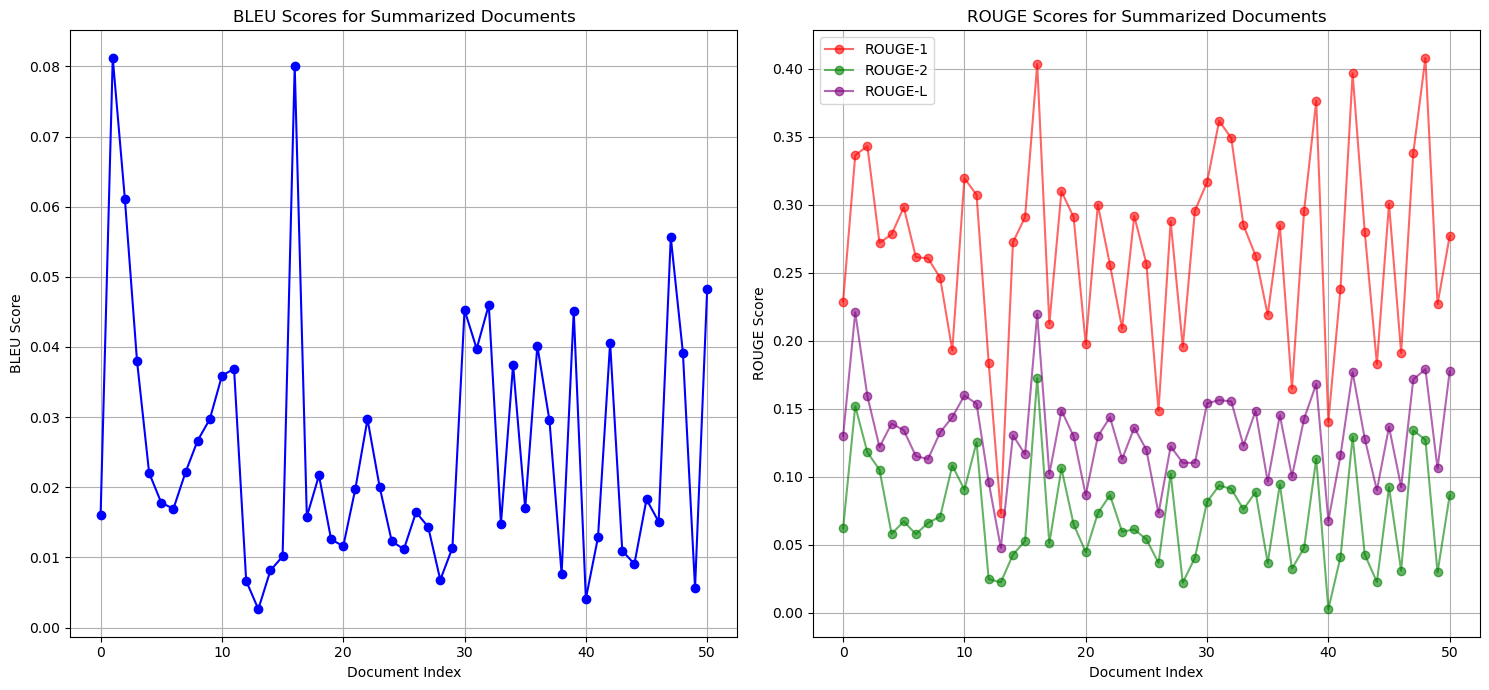

In [15]:
plot_scores(bleu_scores, rouge_scores_list)

BLEU Score Summary:
Mean: 0.0255, Median: 0.0183, Std Dev: 0.0182

ROUGE-1 Score Summary:
Mean: 0.2689, Median: 0.2782, Std Dev: 0.0688

ROUGE-2 Score Summary:
Mean: 0.0724, Median: 0.0661, Std Dev: 0.0370

ROUGE-L Score Summary:
Mean: 0.1311, Median: 0.1298, Std Dev: 0.0336


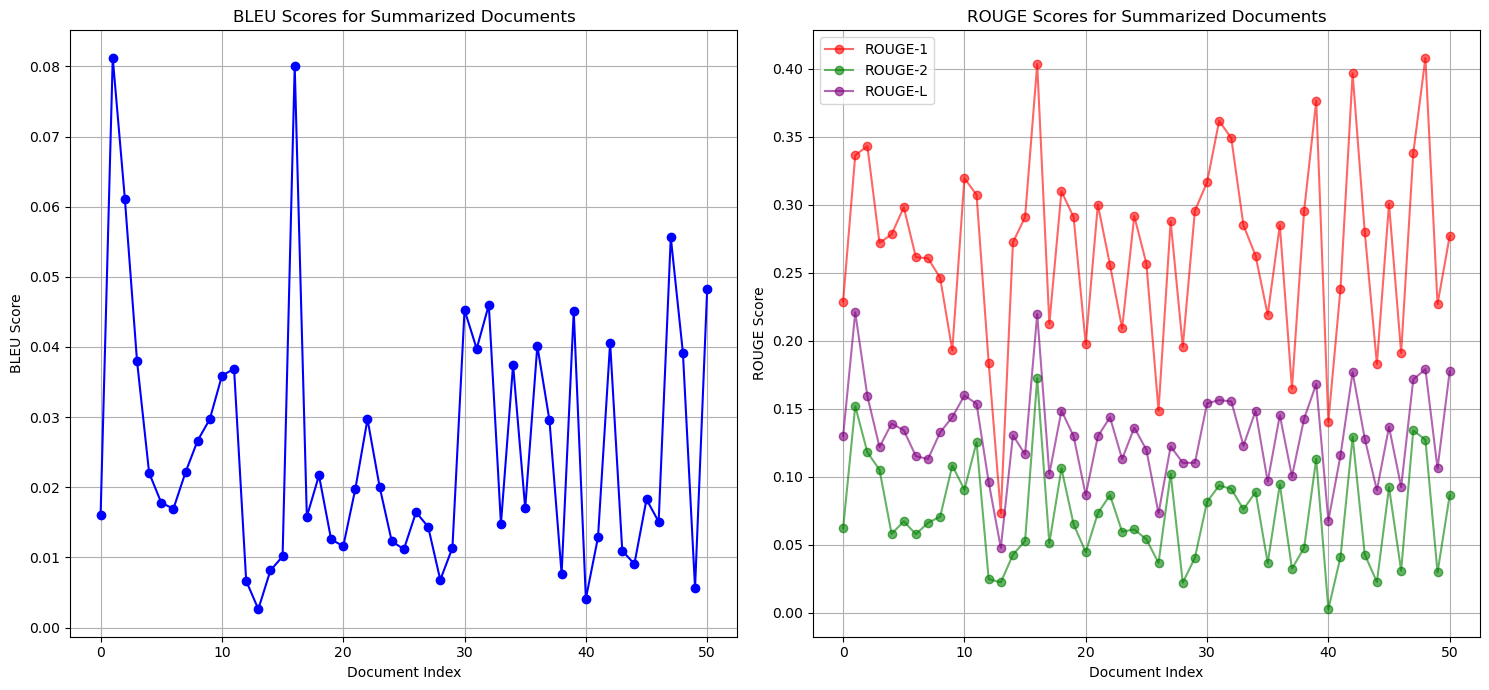

TypeError: save_results() missing 1 required positional argument: 'results_dir'

In [19]:


# Print score summaries
print("BLEU Score Summary:")
print(f"Mean: {np.mean(bleu_scores):.4f}, Median: {np.median(bleu_scores):.4f}, Std Dev: {np.std(bleu_scores):.4f}")

rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores_list]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores_list]
rougel_scores = [score['rougeL'].fmeasure for score in rouge_scores_list]

print("\nROUGE-1 Score Summary:")
print(f"Mean: {np.mean(rouge1_scores):.4f}, Median: {np.median(rouge1_scores):.4f}, Std Dev: {np.std(rouge1_scores):.4f}")

print("\nROUGE-2 Score Summary:")
print(f"Mean: {np.mean(rouge2_scores):.4f}, Median: {np.median(rouge2_scores):.4f}, Std Dev: {np.std(rouge2_scores):.4f}")

print("\nROUGE-L Score Summary:")
print(f"Mean: {np.mean(rougel_scores):.4f}, Median: {np.median(rougel_scores):.4f}, Std Dev: {np.std(rougel_scores):.4f}")

# Optionally, plot the scores
plot_scores(bleu_scores, rouge_scores_list)


In [ ]:


# def extract_entities(text):
#     nlp = spacy.load('en_core_web_md')
#     doc = nlp(text)
#     entities = [(ent.text, ent.label_) for ent in doc.ents]
#     return entities

# def evaluate_entity_coverage(original_text, summary_text):
#     original_entities = extract_entities(original_text)
#     summary_entities = extract_entities(summary_text)
    
#     original_entities_set = set([ent[0] for ent in original_entities])
#     summary_entities_set = set([ent[0] for ent in summary_entities])
    
#     coverage = len(original_entities_set & summary_entities_set) / len(original_entities_set)
#     print(f"Entity Coverage: {coverage:.2f}")
#     print(f"Original Entities: {original_entities}")
#     print(f"Summary Entities: {summary_entities}")
    
#     return coverage